In [5]:
# from pydap.client import open_url
import os
from pydap.client import open_url
import xarray as xr
import datetime
from datetime import timedelta, date
import netCDF4 as nc
from net_cdf_functions import *
from degree_day_equations import single_sine_horizontal_cutoff
import numpy as np


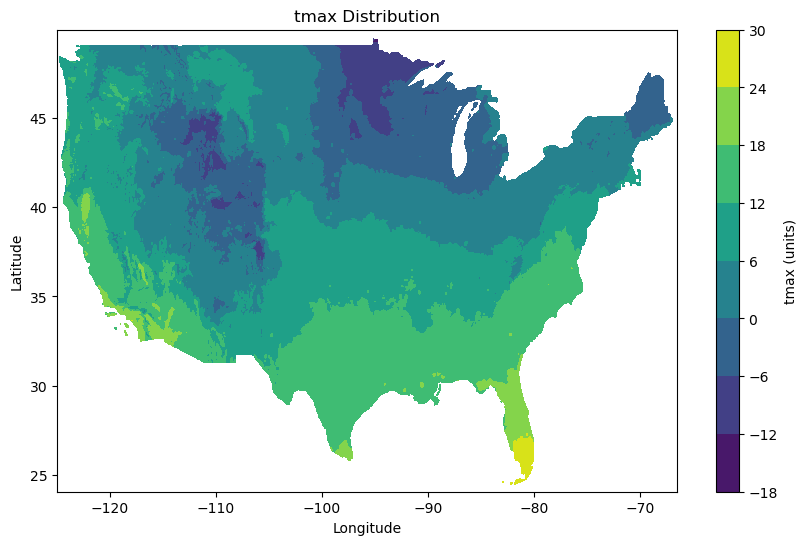

In [4]:
plot_netcdf("data/test/PRISM/2020/PRISM_combo_20200101.nc", "tmax")

In [1]:
def process_netcdf(filepath, output_filepath, LTT, UTT):
    # Open the NetCDF file
    dataset = nc.Dataset(filepath, "r")

    # Extract Tmax and Tmin variables (adjust the variable names as per your NetCDF file)
    Tmax = dataset.variables["tmax"][:]
    Tmin = dataset.variables["tmin"][:]

    # Ensure that Tmax and Tmin arrays are compatible
    assert Tmax.shape == Tmin.shape, "Tmax and Tmin must have the same shape"

    # Apply the single_sine_horizontal_cutoff function element-wise
    vectorized_function = np.vectorize(single_sine_horizontal_cutoff)
    results = vectorized_function(Tmax, Tmin, LTT, UTT)

    # Write results to a new NetCDF file
    with nc.Dataset(output_filepath, "w", format="NETCDF4") as dst:
        # Copy dimensions
        for name, dimension in dataset.dimensions.items():
            dst.createDimension(
                name, (len(dimension) if not dimension.isunlimited() else None)
            )

        # Copy variables except for Tmax and Tmin
        for name, variable in dataset.variables.items():
            if name not in ["tmax", "tmin"]:
                x = dst.createVariable(name, variable.datatype, variable.dimensions)
                dst[name][:] = dataset[name][:]

        # Create new variable for the results
        result_var = dst.createVariable("result", "f4", Tmax.dimensions)
        result_var[:] = results

    # Close the source NetCDF file
    dataset.close()

In [6]:
import numpy as np
import netCDF4 as nc
from concurrent.futures import ProcessPoolExecutor


def compute_mean(sub_array):
    return np.mean(sub_array, axis=1)


def process_netcdf_day(
    input_dir,
    start_year,
    stop_year,
    month_day,
    output_dir,
    output_filename,
    variable_name,
    num_cores,
):
    # Setup
    num_process = num_cores

    # Create list of years and corresponding file paths
    years_list = range(start_year, stop_year + 1)
    file_list = [
        input_dir + str(year) + "/PRISM_combo_" + str(year) + month_day + ".nc"
        for year in years_list
    ]

    base_array = None
    lats = None
    lons = None

    # Process each file and concatenate the data
    for i, each_file in enumerate(file_list):
        # Open the file and read the data
        ds = nc.Dataset(each_file, "r")
        arr = ds.variables[variable_name][:]
        if i == 0:
            lats = ds.variables["latitude"][:]  # Extract latitude
            lons = ds.variables["longitude"][:]  # Extract longitude
        ds.close()

        # Remove singleton dimensions and flatten the array
        print(arr.shape)
        arr = np.squeeze(arr)
        print("post squeeze")
        print(arr.shape)
        arr_flat = arr.reshape((-1, 1))

        # Initialize or concatenate the base array
        if base_array is None:
            base_array = arr_flat
        else:
            base_array = np.concatenate((base_array, arr_flat), axis=1)

    # Compute mean for each grid point
    N = base_array.shape[1]  # Number of time steps
    P = num_process  # Number of partitions
    partitions = list(
        zip(
            np.linspace(0, base_array.shape[0], P, dtype=int)[:-1],
            np.linspace(0, base_array.shape[0], P, dtype=int)[1:],
        )
    )
    partitions[-1] = (
        partitions[-1][0],
        base_array.shape[0],
    )  # Ensure the last partition ends correctly

    # Use ProcessPoolExecutor to process partitions in parallel
    with ProcessPoolExecutor(max_workers=num_process) as executor:
        result = executor.map(compute_mean, [base_array[i:j, :] for i, j in partitions])

    # Combine results and reshape
    means = np.concatenate(list(result), axis=0)
    means = means.reshape(len(lats), len(lons))

    return means
# Example usage
output_array = process_netcdf_day(
    "data/test/PRISM/",
    2000,
    2020,
    "0101",
    "data/test/derived",
    "PRISM_mean_2000-2020",
    variable_name="tmax",
    num_cores=4,
)

(1, 621, 1405)
post squeeze
(621, 1405)
(1, 621, 1405)
post squeeze
(621, 1405)
(1, 621, 1405)
post squeeze
(621, 1405)
(1, 621, 1405)
post squeeze
(621, 1405)
(1, 621, 1405)
post squeeze
(621, 1405)
(1, 621, 1405)
post squeeze
(621, 1405)
(1, 621, 1405)
post squeeze
(621, 1405)
(1, 621, 1405)
post squeeze
(621, 1405)
(1, 621, 1405)
post squeeze
(621, 1405)
(1, 621, 1405)
post squeeze
(621, 1405)
(1, 621, 1405)
post squeeze
(621, 1405)
(1, 621, 1405)
post squeeze
(621, 1405)
(1, 621, 1405)
post squeeze
(621, 1405)
(1, 621, 1405)
post squeeze
(621, 1405)
(1, 621, 1405)
post squeeze
(621, 1405)
(1, 621, 1405)
post squeeze
(621, 1405)
(1, 621, 1405)
post squeeze
(621, 1405)
(1, 621, 1405)
post squeeze
(621, 1405)
(1, 621, 1405)
post squeeze
(621, 1405)
(1, 621, 1405)
post squeeze
(621, 1405)
(1, 621, 1405)
post squeeze
(621, 1405)


In [3]:
plot_netcdf(output_array, "mean")

An error occurred: [Errno 36] File name too long: '[[-3.39999995e+38 -3.39999995e+38 -3.39999995e+38 ... -3.39999995e+38\n  -3.39999995e+38 -3.39999995e+38]\n [-3.39999995e+38 -3.39999995e+38 -3.39999995e+38 ... -3.39999995e+38\n  -3.39999995e+38 -3.39999995e+38]\n [-3.39999995e+38 -3.39999995e+38 -3.39999995e+38 ... -3.39999995e+38\n  -3.39999995e+38 -3.39999995e+38]\n ...\n [-3.39999995e+38 -3.39999995e+38 -3.39999995e+38 ... -3.39999995e+38\n  -3.39999995e+38 -3.39999995e+38]\n [-3.39999995e+38 -3.39999995e+38 -3.39999995e+38 ... -3.39999995e+38\n  -3.39999995e+38 -3.39999995e+38]\n [-3.39999995e+38 -3.39999995e+38 -3.39999995e+38 ... -3.39999995e+38\n  -3.39999995e+38 -3.39999995e+38]]'


In [64]:
print(output_array)

[[-3.39999995e+38 -3.39999995e+38 -3.39999995e+38 ... -3.39999995e+38
  -3.39999995e+38 -3.39999995e+38]
 [-3.39999995e+38 -3.39999995e+38 -3.39999995e+38 ... -3.39999995e+38
  -3.39999995e+38 -3.39999995e+38]
 [-3.39999995e+38 -3.39999995e+38 -3.39999995e+38 ... -3.39999995e+38
  -3.39999995e+38 -3.39999995e+38]
 ...
 [-3.39999995e+38 -3.39999995e+38 -3.39999995e+38 ... -3.39999995e+38
  -3.39999995e+38 -3.39999995e+38]
 [-3.39999995e+38 -3.39999995e+38 -3.39999995e+38 ... -3.39999995e+38
  -3.39999995e+38 -3.39999995e+38]
 [-3.39999995e+38 -3.39999995e+38 -3.39999995e+38 ... -3.39999995e+38
  -3.39999995e+38 -3.39999995e+38]]


In [ ]:
samp

('https://tds.climate.ncsu.edu/thredds/dodsC/prism/daily/combo/2020/PRISM_combo_20201231.nc',
 <DatasetType with children 't', 'ppt', 'tmean', 'tmin', 'tmax', 'longitude', 'latitude'>)